In [1]:
# ============================================
# 0. CONFIG
# ============================================
CSV_PATH = "ai4i2020.csv"   # 연습용 CSV (ai4i2020)

# 여러 개 연속 타깃 (예시)
TARGET_COLS = [
    "Tool_wear_min",
    "Torque_Nm",
    "Air_temperature_K"
]

ID_COL = "UDI"                 # ID
ID_LIKE_COLS = ["Product_ID"]  # 사실상 ID인 문자열 컬럼들 (피처에서 제외)

CATEGORICAL_COLS = ["Type"]    # 범주형 컬럼들

RANDOM_STATE = 42
TEST_SIZE = 0.2                # train/valid 비율


In [2]:
# ============================================
# 1. IMPORTS
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
pd.set_option("display.max_columns", 100)


In [3]:
# ============================================
# 2. 데이터 로드 + 컬럼 이름 정리 + 타깃 EDA
# ============================================
df_raw = pd.read_csv(CSV_PATH)

print("=== Raw Shape ===", df_raw.shape)
display(df_raw.head())
print(df_raw.info())
print("\n=== Raw Missing values ===")
print(df_raw.isnull().sum())

def clean_column_name(col: str) -> str:
    return (
        col.strip()
           .replace(" ", "_")
           .replace("[", "")
           .replace("]", "")
           .replace("(", "")
           .replace(")", "")
           .replace("/", "_")
           .replace("%", "pct")
           .replace("<", "lt")
           .replace(">", "gt")
    )

df = df_raw.copy()
df.columns = [clean_column_name(c) for c in df.columns]

print("\n=== Cleaned columns ===")
print(df.columns.tolist())


=== Raw Shape === (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)


=== Target(Tool_wear_min) 통계 ===


,Tool_wear_min
count,10000.000000
mean,107.951000
std,63.654147
min,0.000000
25%,53.000000
50%,108.000000
75%,162.000000
max,253.000000


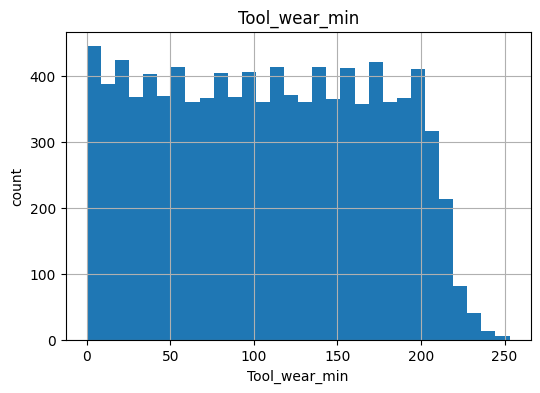


=== Target(Torque_Nm) 통계 ===


,Torque_Nm
count,10000.000000
mean,39.986910
std,9.968934
min,3.800000
25%,33.200000
50%,40.100000
75%,46.800000
max,76.600000


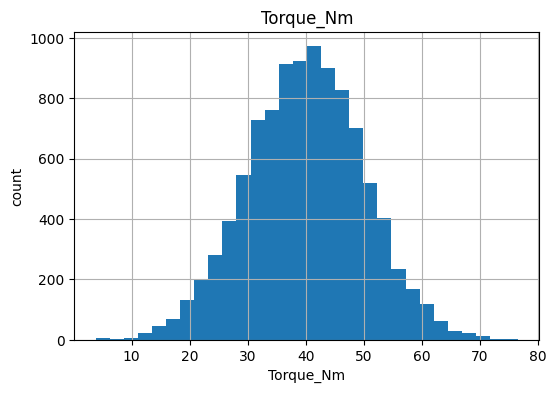


=== Target(Air_temperature_K) 통계 ===


,Air_temperature_K
count,10000.000000
mean,300.004930
std,2.000259
min,295.300000
25%,298.300000
50%,300.100000
75%,301.500000
max,304.500000


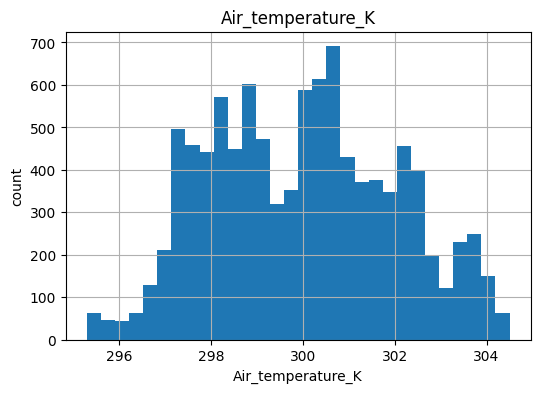

In [4]:
# 타깃들 통계 & 분포
for tgt in TARGET_COLS:
    if tgt not in df.columns:
        print(f"[경고] 타깃 {tgt} 가 df에 없음, 스킵")
        continue

    print(f"\n=== Target({tgt}) 통계 ===")
    display(df[tgt].describe())

    df[tgt].hist(bins=30)
    plt.title(tgt)
    plt.xlabel(tgt)
    plt.ylabel("count")
    plt.show()


In [5]:
# ============================================
# 3. 범주형 / 수치형 분리 + 결측/이상치 탐지
# ============================================
# 타깃 / ID / ID-like 제외 피처
drop_cols = TARGET_COLS + [ID_COL] + ID_LIKE_COLS
feature_cols = [c for c in df.columns if c not in drop_cols]

X_full = df[feature_cols].copy()
Y_full = df[TARGET_COLS].copy()   # (n_samples, n_targets)

# dtype 기반 자동 분리
cat_cols_auto = X_full.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols_auto = X_full.select_dtypes(include=[np.number]).columns.tolist()

# CONFIG에서 지정한 범주형들도 포함
cat_cols = sorted(set(cat_cols_auto) | set(c for c in CATEGORICAL_COLS if c in X_full.columns))
num_cols = num_cols_auto  # 진짜 숫자 컬럼만

print("범주형 컬럼:", cat_cols)
print("수치형 컬럼:", num_cols)

print("\n=== 결측치 개수 (수치형) ===")
print(X_full[num_cols].isnull().sum())

print("\n=== 결측치 개수 (범주형) ===")
print(X_full[cat_cols].isnull().sum())


범주형 컬럼: ['Type']
수치형 컬럼: ['Process_temperature_K', 'Rotational_speed_rpm', 'Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

=== 결측치 개수 (수치형) ===
Process_temperature_K    0
Rotational_speed_rpm     0
Machine_failure          0
TWF                      0
HDF                      0
PWF                      0
OSF                      0
RNF                      0
dtype: int64

=== 결측치 개수 (범주형) ===
Type    0
dtype: int64


In [6]:
# IQR 기반 이상치 개수 확인
def detect_outliers_iqr(s: pd.Series):
    s = s.dropna()
    if s.empty:
        return 0
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((s < lower) | (s > upper)).sum()

print("\n=== 이상치 개수(IQR 기준) ===")
for col in num_cols:
    n_out = detect_outliers_iqr(X_full[col])
    print(f"{col}: {n_out}")



=== 이상치 개수(IQR 기준) ===
Process_temperature_K: 0
Rotational_speed_rpm: 418
Machine_failure: 339
TWF: 46
HDF: 115
PWF: 95
OSF: 98
RNF: 19


In [7]:
# ============================================
# 4. 전처리
#   - 결측치 처리
#   - 이상치 클리핑
#   - 수치형 스케일링
#   - 범주형 원-핫 인코딩
#   - PCA latent feature
# ============================================

# 4-1) 결측치 처리
X_num = X_full[num_cols].copy()
X_cat = X_full[cat_cols].copy()

X_num_imputed = X_num.fillna(X_num.median())
X_cat_imputed = X_cat.fillna("Unknown")

# 4-2) 이상치 처리: 1% ~ 99% 구간으로 클리핑
for col in num_cols:
    lower = X_num_imputed[col].quantile(0.01)
    upper = X_num_imputed[col].quantile(0.99)
    X_num_imputed[col] = X_num_imputed[col].clip(lower, upper)

# 4-3) 수치형 스케일링
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_num_imputed),
    columns=num_cols,
    index=X_num_imputed.index,
)

# 4-4) 범주형 원-핫 인코딩
X_cat_oh = pd.get_dummies(X_cat_imputed, columns=cat_cols, drop_first=True)

print("X_num_scaled shape:", X_num_scaled.shape)
print("X_cat_oh shape:", X_cat_oh.shape)


X_num_scaled shape: (10000, 8)
X_cat_oh shape: (10000, 2)


In [8]:
# 4-5) PCA latent feature (수치형 기반)
if len(num_cols) > 0:
    n_components = min(3, len(num_cols))
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    pca_components = pca.fit_transform(X_num_scaled)

    X_pca = pd.DataFrame(
        pca_components,
        columns=[f"pca_{i+1}" for i in range(n_components)],
        index=X_num_scaled.index,
    )

    print("PCA explained variance ratio:", pca.explained_variance_ratio_)
    print("X_pca shape:", X_pca.shape)
else:
    X_pca = pd.DataFrame(index=X_num_scaled.index)
    print("수치형 피처가 없어서 PCA 스킵")

# 4-6) 최종 피처 결합
X_all = pd.concat([X_num_scaled, X_cat_oh, X_pca], axis=1)
print("최종 피처 shape:", X_all.shape)


PCA explained variance ratio: [0.40497177 0.25419982 0.23522578]
X_pca shape: (10000, 3)
최종 피처 shape: (10000, 13)


In [9]:
# ============================================
# 5. train/valid 분할 (한 번에 다변량)
# ============================================
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_all, Y_full,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("Y_train shape:", Y_train.shape)
print("Y_valid shape:", Y_valid.shape)

print("\n=== Y_train 타깃별 통계 ===")
display(Y_train.describe())


X_train shape: (8000, 13)
X_valid shape: (2000, 13)
Y_train shape: (8000, 3)
Y_valid shape: (2000, 3)

=== Y_train 타깃별 통계 ===


,Tool_wear_min,Torque_Nm,Air_temperature_K
count,8000.000000,8000.000000,8000.000000
mean,108.068750,40.007800,300.009925
std,63.225052,9.979156,2.002224
min,0.000000,3.800000,295.300000
25%,53.000000,33.200000,298.300000
50%,108.000000,40.200000,300.100000
75%,162.000000,46.800000,301.500000
max,253.000000,76.200000,304.500000


In [10]:
# ============================================
# 6. 회귀 평가 함수
# ============================================
def eval_regressor(y_true, y_pred, print_report=True):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    if print_report:
        print("MAE :", mae)
        print("RMSE:", rmse)
        print("R^2 :", r2)

    return {"mae": mae, "rmse": rmse, "r2": r2}


In [11]:
def eval_multioutput_regression(Y_true: pd.DataFrame, Y_pred: np.ndarray, target_cols):
    """
    다변량 회귀에서 각 타깃별 MAE/RMSE/R2를 출력하고 DataFrame으로 반환
    """
    metrics = {}
    for i, col in enumerate(target_cols):
        if col not in Y_true.columns:
            continue
        y_true = Y_true[col]
        y_pred = Y_pred[:, i]
        metrics[col] = eval_regressor(y_true, y_pred, print_report=False)

    metrics_df = pd.DataFrame(metrics).T
    print("=== Multi-target regression metrics ===")
    display(metrics_df)
    return metrics_df


In [12]:
# ============================================
# 7. 모델 1: Multi-output RandomForestRegressor
# ============================================
print("=== RandomForestRegressor (multi-output) ===")
rf_multi = RandomForestRegressor(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_multi.fit(X_train, Y_train)          # Y_train: DataFrame (multi-target)
Y_pred_rf = rf_multi.predict(X_valid)   # ndarray (n_samples, n_targets)

metrics_rf = eval_multioutput_regression(Y_valid, Y_pred_rf, TARGET_COLS)


=== RandomForestRegressor (multi-output) ===
=== Multi-target regression metrics ===


,mae,rmse,r2
Tool_wear_min,58.701822,70.053827,-0.149490
Torque_Nm,3.115800,4.097922,0.829609
Air_temperature_K,0.818470,1.008910,0.743542


In [13]:
# ============================================
# 8. 모델 2: MultiOutputRegressor + XGBRegressor
# ============================================
print("\n=== MultiOutputRegressor(XGBRegressor) ===")

base_xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_multi_reg = MultiOutputRegressor(base_xgb)
xgb_multi_reg.fit(X_train, Y_train)

Y_pred_xgb = xgb_multi_reg.predict(X_valid)

metrics_xgb = eval_multioutput_regression(Y_valid, Y_pred_xgb, TARGET_COLS)



=== MultiOutputRegressor(XGBRegressor) ===
=== Multi-target regression metrics ===


,mae,rmse,r2
Tool_wear_min,55.798832,65.214393,0.003842
Torque_Nm,2.958747,3.889601,0.846492
Air_temperature_K,0.792754,0.956622,0.769436


In [14]:
# ============================================
# 9. 랭킹 리포트 함수 (회귀/분류 공용)
# ============================================
def make_rank_report(
    df,
    score,
    id_cols,
    extra_cols=None,
    k_ratio=None,
    k_abs=None,
    threshold=None,
    group_col=None,
    max_rows=30
):
    """
    다양한 '상위 x%, N개, threshold, 그룹별' 리포트를 공통으로 만드는 함수
    """

    tmp = df.copy()
    tmp["score"] = score

    base_cols = list(id_cols)
    if extra_cols is not None:
        base_cols += list(extra_cols)
    base_cols = [c for c in base_cols if c in tmp.columns] + ["score"]

    # 1) 그룹별 리포트
    if group_col is not None and group_col in tmp.columns:
        reports = []
        for g, g_df in tmp.groupby(group_col):
            g_sorted = g_df.sort_values("score", ascending=False)

            if threshold is not None:
                g_sel = g_sorted[g_sorted["score"] >= threshold]
            elif k_abs is not None:
                g_sel = g_sorted.head(k_abs)
            elif k_ratio is not None:
                k = max(1, int(len(g_sorted) * k_ratio))
                g_sel = g_sorted.head(k)
            else:
                g_sel = g_sorted.head(max_rows)

            g_sel = g_sel[base_cols].head(max_rows)
            g_sel[group_col] = g
            reports.append(g_sel)

        if len(reports) == 0:
            return pd.DataFrame(columns=base_cols + [group_col])

        report_df = pd.concat(reports, axis=0)
        report_df = report_df.sort_values("score", ascending=False)
        return report_df.head(max_rows)

    # 2) 전체 기준 리포트
    tmp_sorted = tmp.sort_values("score", ascending=False)

    if threshold is not None:
        sel = tmp_sorted[tmp_sorted["score"] >= threshold]
    elif k_abs is not None:
        sel = tmp_sorted.head(k_abs)
    elif k_ratio is not None:
        k = max(1, int(len(tmp_sorted) * k_ratio))
        sel = tmp_sorted.head(k)
    else:
        sel = tmp_sorted.head(max_rows)

    return sel[base_cols].head(max_rows)


In [15]:
# ============================================
# 10. 타깃별 "예측값 상위 5% (최대 30건)" 리포트
#     XGB 다변량 회귀 예측값 기준
# ============================================
valid_index = X_valid.index
df_valid = df.loc[valid_index].copy()

for i, tgt in enumerate(TARGET_COLS):
    if tgt not in df_valid.columns:
        print(f"\n[경고] {tgt} 컬럼이 df_valid에 없음, 리포트 스킵")
        continue

    score = Y_pred_xgb[:, i]   # 해당 타깃의 예측값

    print(f"\n=== [{tgt}] 예측값 상위 5% (최대 30건) 리포트 ===")
    report_top5 = make_rank_report(
        df=df_valid,
        score=score,
        id_cols=[ID_COL],
        extra_cols=["Type", tgt],
        k_ratio=0.05,
        max_rows=30
    )
    display(report_top5)



=== [Tool_wear_min] 예측값 상위 5% (최대 30건) 리포트 ===


,UDI,Type,Tool_wear_min,score
1087,1088,H,206,218.936676
9018,9019,L,217,216.745682
3529,3530,L,214,210.970291
6478,6479,L,145,209.075668
586,587,L,222,206.850204
1162,1163,L,202,204.366257
7087,7088,L,217,204.204483
2075,2076,L,195,201.279846
603,604,L,31,200.677948
5399,5400,H,246,196.886475



=== [Torque_Nm] 예측값 상위 5% (최대 30건) 리포트 ===


,UDI,Type,Torque_Nm,score
3350,3351,L,62.6,67.598282
3684,3685,L,65.3,66.935097
7763,7764,L,76.6,66.383202
1496,1497,L,69.4,66.320015
1144,1145,L,69.1,65.083160
4220,4221,M,65.9,64.831589
1833,1834,L,61.0,63.933517
9084,9085,L,75.4,62.568081
2199,2200,M,58.0,62.328419
3000,3001,H,72.8,61.547089



=== [Air_temperature_K] 예측값 상위 5% (최대 30건) 리포트 ===


,UDI,Type,Air_temperature_K,score
5170,5171,M,304.1,304.159241
5100,5101,M,304.2,304.152252
5098,5099,L,304.2,304.143768
5090,5091,M,303.9,304.134583
5190,5191,L,304.1,304.124023
5028,5029,M,303.9,304.105408
5284,5285,M,303.8,304.097717
5133,5134,L,304.1,304.083771
5306,5307,H,304.0,304.082611
5123,5124,M,304.2,304.082550


In [16]:
# ============================================
# 11. (선택) 특정 타깃에 대해 threshold 기반 리포트
#     예: Tool_wear_min 예측값 >= 200
# ============================================
target_for_threshold = "Tool_wear_min"
threshold_value = 200   # 데이터 보고 적절히 조정

if target_for_threshold in TARGET_COLS and target_for_threshold in df_valid.columns:
    idx = TARGET_COLS.index(target_for_threshold)
    score = Y_pred_xgb[:, idx]

    print(f"\n=== [{target_for_threshold}] 예측값 >= {threshold_value} (최대 50건) 리포트 ===")
    report_th = make_rank_report(
        df=df_valid,
        score=score,
        id_cols=[ID_COL],
        extra_cols=["Type", target_for_threshold],
        threshold=threshold_value,
        max_rows=50
    )
    display(report_th)
else:
    print(f"[경고] {target_for_threshold} 가 TARGET_COLS 또는 df_valid에 없음")



=== [Tool_wear_min] 예측값 >= 200 (최대 50건) 리포트 ===


,UDI,Type,Tool_wear_min,score
1087,1088,H,206,218.936676
9018,9019,L,217,216.745682
3529,3530,L,214,210.970291
6478,6479,L,145,209.075668
586,587,L,222,206.850204
1162,1163,L,202,204.366257
7087,7088,L,217,204.204483
2075,2076,L,195,201.279846
603,604,L,31,200.677948


In [17]:
# ============================================
# 12. SHAP으로 XGB 다변량 회귀 해석
#     - MultiOutputRegressor는 타깃별로 XGBRegressor 하나씩 있음
#     - 여기서는 첫 번째 타깃(TARGET_COLS[0]) 기준 예시
# ============================================
!pip install shap -q
import shap

shap.initjs()


In [18]:
# 검증셋 일부 샘플링
X_valid_df = X_valid.copy()

X_valid_sample = X_valid_df.sample(
    n=min(300, len(X_valid_df)),
    random_state=RANDOM_STATE
)

print("X_valid_sample shape:", X_valid_sample.shape)


X_valid_sample shape: (300, 13)



=== SHAP Summary for target: Tool_wear_min ===


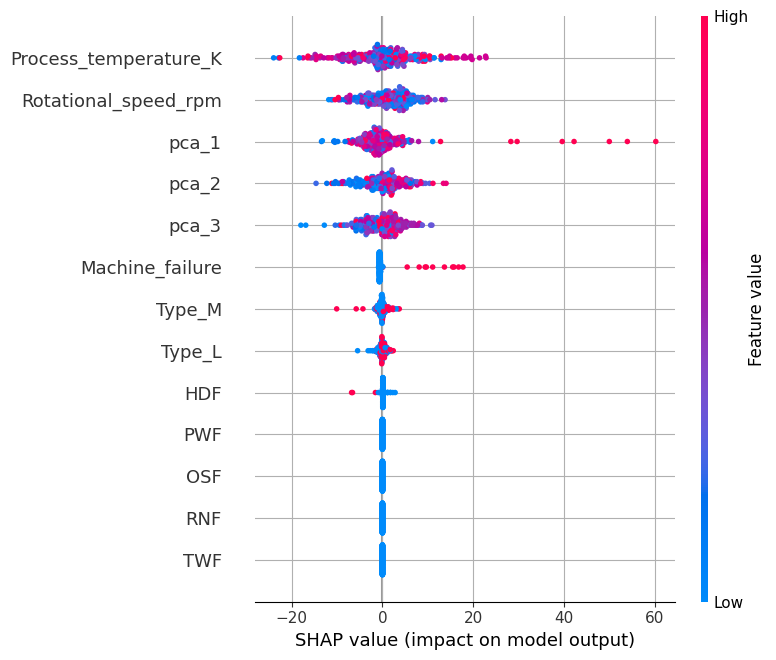

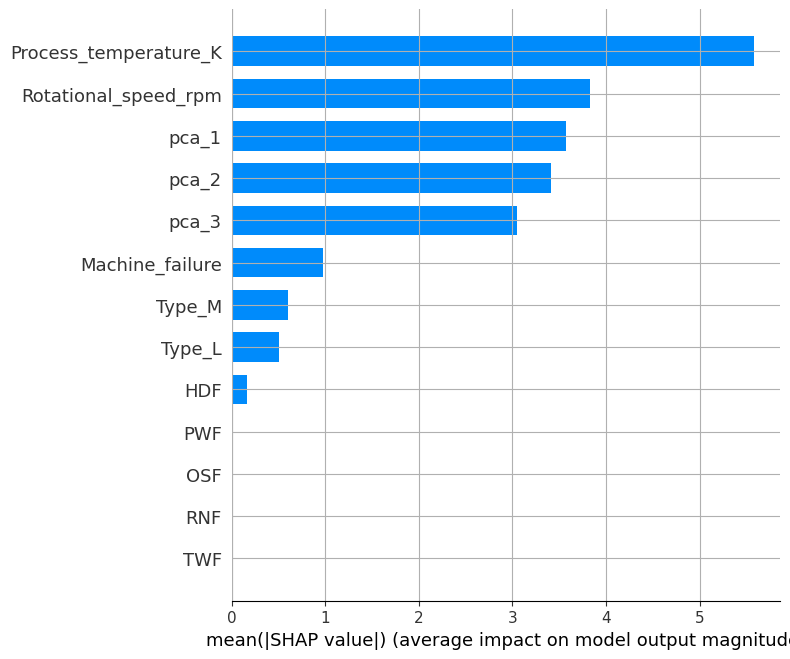

In [19]:
# 첫 번째 타깃용 XGBRegressor 꺼내서 SHAP 해석
if hasattr(xgb_multi_reg, "estimators_") and len(xgb_multi_reg.estimators_) > 0:
    target_idx = 0
    target_name = TARGET_COLS[target_idx]

    est0 = xgb_multi_reg.estimators_[target_idx]   # XGBRegressor for first target

    explainer0 = shap.TreeExplainer(est0)
    shap_values0 = explainer0.shap_values(X_valid_sample)

    print(f"\n=== SHAP Summary for target: {target_name} ===")
    shap.summary_plot(
        shap_values0,
        X_valid_sample,
        feature_names=X_valid_sample.columns,
        show=True
    )

    # bar plot (중요도 순서)
    shap.summary_plot(
        shap_values0,
        X_valid_sample,
        feature_names=X_valid_sample.columns,
        plot_type="bar",
        show=True
    )
else:
    print("[경고] xgb_multi_reg.estimators_ 를 찾을 수 없음. MultiOutputRegressor가 제대로 학습됐는지 확인.")
